# UNet Review
- UNet Pytorch
- UNet: Convolutional Networks for Biomedical Image Segmentation
- https://youtube.com/watch?v=sSxdQq9CCx0&si=EnSIkaIECMiOmarE

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets

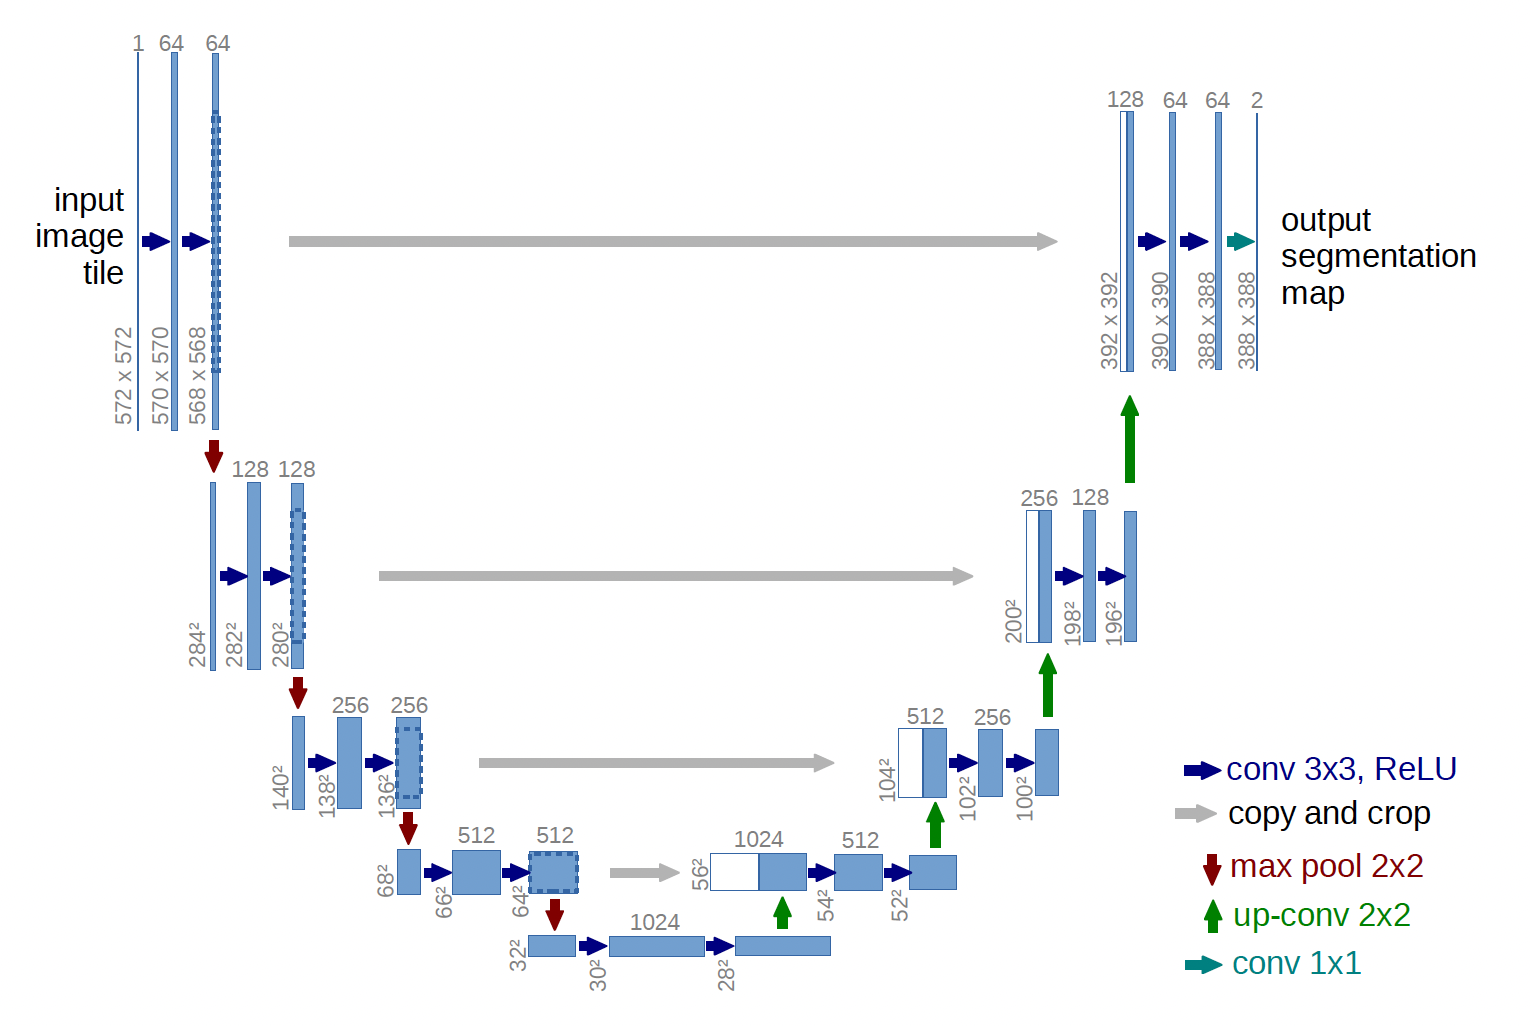

## UNet 구축

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # conv 3x3, batch normalization, relu
        def CB(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            
            conv_block = nn.Sequential(*layers)
            return conv_block
        
        # UNet Encoder
        self.enc1_1 = CB(in_channels=1, out_channels=64)
        self.enc1_2 = CB(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CB(in_channels=64, out_channels=128)
        self.enc2_2 = CB(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3_1 = CB(in_channels=128, out_channels=256)
        self.enc3_2 = CB(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CB(in_channels=256, out_channels=512)
        self.enc4_2 = CB(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CB(in_channels=512, out_channels=1024)
        
        # UNet Decoder
        self.dec5_1 = CB(in_channels=1024, out_channels=512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)
        
        # in_channels = 512*2인 이유는 encoder에서 사용했던 피쳐맵을 decoder에서도 사용할 수 있도록
        # forward에서 dec와 enc을 concat해주기 때문 
        self.dec4_2 = CB(in_channels=512*2, out_channels=512)  
        self.dec4_1 = CB(in_channels=512, out_channels=256)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3_2 = CB(in_channels=256*2, out_channels=256)
        self.dec3_1 = CB(in_channels=256, out_channels=128)
        
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2_2 = CB(in_channels=128*2, out_channels=128)
        self.dec2_1 = CB(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1_2 = CB(in_channels=64*2, out_channels=64)
        self.dec1_1 = CB(in_channels=64, out_channels=64)
        
        self.fc = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1, padding=0, bias=True)
        
        def forward(self, x):
            # Encoder
            enc1_1 = self.enc1_1(x)
            enc1_2 = self.enc1_2(enc1_1)
            pool1 = self.pool1(enc1_2)
            
            enc2_1 = self.enc2_1(pool1)
            enc2_2 = self.enc2_2(enc2_1)
            pool2 = self.pool2(enc2_2)
            
            enc3_1 = self.enc3_1(pool2)
            enc3_2 = self.enc3_2(enc3_1)
            pool3 = self.pool3(enc3_2)
            
            enc4_1 = self.enc4_1(pool3)
            enc4_2 = self.enc4_2(enc4_1)
            pool4 = self.pool4(enc4_2)
            
            enc5_1 = self.enc5_1(pool4)
            
            # Decoder
            dec5_1 = self.dec5_1(enc5_1)
            
            unpool4 = self.unpool4(dec5_1)
            
            # UNet 구조 중 encoder에서 사용했던 피쳐맵을 decoder에서 동일하게 사용하도록 구축
            # dim=[0:batch, 1:channel, 2:height, 3:width]
            cat4 = torch.cat((unpool4, enc4_2), dim=1)
            dec4_2 = self.dec4_2(cat4)
            dec4_1 = self.dec4_1(dec4_2)
            
            unpool3 = self.unpool3(dec4_1)
            cat3 = torch.cat((unpool3, enc3_2), dim=1)
            dec3_2 = self.dec3_2(cat3)
            dec3_1 = self.dec3_1(dec3_2)
            
            unpool2 = self.unpool2(dec3_1)
            cat2 = torch.cat((unpool2, enc2_2), dim=1)
            dec2_2 = self.dec2_2(cat2)
            dec2_1 = self.dec2_1(dec2_2)
            
            unpool1 = self.unpool1(dec2_1)
            cat1 = torch.cat((unpool1, enc1_2), dim=1)
            dec1_2 = self.dec1_2(cat1)
            dec1_1 = self.dec1_1(dec1_2)
            
            x = self.fc(dec1_1)
            
            return x
            

In [4]:
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    x = torch.randn(4, 3, 224, 224).to(device)
    model = UNet().to(device)
    output = model(x)
    print('output size:', output.size())
    
    summary(model, input_size=(3, 224, 224))

NotImplementedError: Module [UNet] is missing the required "forward" function

## UNet 실습

### 데이터

### 학습

In [ ]:
# 변수설정
lr = 0.001
batch_size = 4
n_epoch = 100

# 데이터 저장경로
data_dir = './datasets'

# train model 저장경로
ckpt_dir = './checkpoint'

# tensorboard log 저장경로
log_dir = './log'

# cpu, gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')